In [38]:
import sympy as sp
import numpy as np
import math
from scipy.optimize import brentq

In [39]:
h_num = 35.0
H_num = 150.0
D_num = 8.0
t_num = 0.1

M_num = 1.0e6
J_num = 1.6e9
c_num = 30e3

E_num = 210e9
rho_num = 7850.0
rho_f_num = 1025.0
Ca_num = 1.0
T_num = 0.0

Di_num = D_num - 2.0*t_num
A_num = math.pi/4.0 * (D_num**2 - Di_num**2)
I_num = math.pi/64.0 * (D_num**4 - Di_num**4)

In [40]:
# -----------------------------
# Symbols
# -----------------------------
z, w = sp.symbols('z wega', real=True)
E, I, T = sp.symbols('E I T', positive=True, real=True)
rho, A = sp.symbols('rho A', positive=True, real=True)
rho_f, Ca, D = sp.symbols('rho_f Ca D', positive=True, real=True)
h, H = sp.symbols('h H', positive=True, real=True)
J, Mtip, c = sp.symbols('J M c', real=True)  
EI = E*I

# Effective mass per length (submerged) and (above water)
m1 = rho*A + rho_f*Ca*sp.pi*D**2/4   # submerged
m2 = rho*A                            # above water

# Spatial ODE parameters
beta1_4 = (w**2 * m1) / EI
beta2_4 = (w**2 * m2) / EI

# Define alpha^2 and mu^2 exactly as in your derivation
alpha1_sq = (-T/EI + sp.sqrt((T/EI)**2 + 4*beta1_4))/2
mu1_sq    = ( T/EI + sp.sqrt((T/EI)**2 + 4*beta1_4))/2

alpha2_sq = (-T/EI + sp.sqrt((T/EI)**2 + 4*beta2_4))/2
mu2_sq    = ( T/EI + sp.sqrt((T/EI)**2 + 4*beta2_4))/2

alpha1, mu1 = sp.sqrt(alpha1_sq), sp.sqrt(mu1_sq)
alpha2, mu2 = sp.sqrt(alpha2_sq), sp.sqrt(mu2_sq)

# -----------------------------
# General solutions W1(z), W2(z)
# -----------------------------
A1,B1,C1,D1 = sp.symbols('A1 B1 C1 D1')
A2,B2,C2,D2 = sp.symbols('A2 B2 C2 D2')

W1 = A1*sp.cosh(alpha1*z) + B1*sp.sinh(alpha1*z) + C1*sp.cos(mu1*z) + D1*sp.sin(mu1*z)
W2 = A2*sp.cosh(alpha2*z) + B2*sp.sinh(alpha2*z) + C2*sp.cos(mu2*z) + D2*sp.sin(mu2*z)

# Derivatives you will need for beam BCs
W1_1 = sp.diff(W1, z)
W1_2 = sp.diff(W1, z, 2)
W1_3 = sp.diff(W1, z, 3)

W2_1 = sp.diff(W2, z)
W2_2 = sp.diff(W2, z, 2)
W2_3 = sp.diff(W2, z, 3)

# Beam resultants (Euler-Bernoulli with axial tension T):
# Mwent:   M = EI * W''
# Shear:    V = EI * W''' + T * W'
M1 = EI*W1_2
V1 = EI*W1_3 + T*W1_1

M2 = EI*W2_2
V2 = EI*W2_3 + T*W2_1



# Define the boundary conditions and constant vector, form the frequency matrix with only no values assigned to variables

In [41]:
# 8 boundary/interface equations (LHS = 0 vorm)
eq1 = W1.subs(z, -h)                        # w1(-h)=0
eq2 = W1_1.subs(z, -h)                      # w1'(-h)=0

eq3 = W1.subs(z, 0)  - W2.subs(z, 0)        # w1(0)=w2(0)
eq4 = W1_1.subs(z, 0) - W2_1.subs(z, 0)     # w1'(0)=w2'(0)
eq5 = W1_2.subs(z, 0) - W2_2.subs(z, 0)     # w1''(0)=w2''(0)
eq6 = W1_3.subs(z, 0) - W2_3.subs(z, 0)     # w1'''(0)=w2'''(0)

# Top BCs at z=H with harmonic time dependence w(z,t)=W(z)*exp(i*w*t)
# EI w2_zz + J w2_ttz = 0  -> EI*W2'' - J*w^2*W2' = 0
eq7 = EI*W2_2.subs(z, H) - J*w**2*W2_1.subs(z, H)

# EI w2_zzz + M w2_tt + c w2_t = 0
# -> EI*W2''' - M*w^2*W2 + i*c*w*W2 = 0
eq8 = EI*W2_3.subs(z, H) - Mtip*w**2*W2.subs(z, H) + sp.I*c*w*W2.subs(z, H)

# Collect them
eqs = [eq1,eq2,eq3,eq4,eq5,eq6,eq7,eq8]

# Unknown constants vector
Cvec = sp.Matrix([A1,B1,C1,D1,A2,B2,C2,D2])

# Build K(w) by extracting coefficients of the constants
K = sp.Matrix([[sp.diff(expr, cst) for cst in Cvec] for expr in eqs])
print("K(w) matrix:")
print(K)

K(w) matrix:
Matrix([[cosh(h*sqrt(sqrt(4*wega**2*(A*rho + pi*Ca*D**2*rho_f/4)/(E*I) + T**2/(E**2*I**2))/2 - T/(2*E*I))), -sinh(h*sqrt(sqrt(4*wega**2*(A*rho + pi*Ca*D**2*rho_f/4)/(E*I) + T**2/(E**2*I**2))/2 - T/(2*E*I))), cos(h*sqrt(sqrt(4*wega**2*(A*rho + pi*Ca*D**2*rho_f/4)/(E*I) + T**2/(E**2*I**2))/2 + T/(2*E*I))), -sin(h*sqrt(sqrt(4*wega**2*(A*rho + pi*Ca*D**2*rho_f/4)/(E*I) + T**2/(E**2*I**2))/2 + T/(2*E*I))), 0, 0, 0, 0], [-sqrt(sqrt(4*wega**2*(A*rho + pi*Ca*D**2*rho_f/4)/(E*I) + T**2/(E**2*I**2))/2 - T/(2*E*I))*sinh(h*sqrt(sqrt(4*wega**2*(A*rho + pi*Ca*D**2*rho_f/4)/(E*I) + T**2/(E**2*I**2))/2 - T/(2*E*I))), sqrt(sqrt(4*wega**2*(A*rho + pi*Ca*D**2*rho_f/4)/(E*I) + T**2/(E**2*I**2))/2 - T/(2*E*I))*cosh(h*sqrt(sqrt(4*wega**2*(A*rho + pi*Ca*D**2*rho_f/4)/(E*I) + T**2/(E**2*I**2))/2 - T/(2*E*I))), sqrt(sqrt(4*wega**2*(A*rho + pi*Ca*D**2*rho_f/4)/(E*I) + T**2/(E**2*I**2))/2 + T/(2*E*I))*sin(h*sqrt(sqrt(4*wega**2*(A*rho + pi*Ca*D**2*rho_f/4)/(E*I) + T**2/(E**2*I**2))/2 + T/(2*E*I))), s

# Assign values to variables

In [42]:
vals = {
    E: E_num,
    I: I_num,
    T: T_num,
    rho: rho_num,
    A: A_num,
    rho_f: rho_f_num,
    Ca: Ca_num,
    D: D_num,
    h: h_num,
    H: H_num,
    J: J_num,
    Mtip: M_num,
    c: 0.0
}

# Make the frequency matrix and extract the natural frequencies

In [ ]:
# Numerieke determinantfunctie (snel)
K_w = K.subs(vals)
K_func = sp.lambdify(w, K_w, modules='numpy')

def detK_numeric(omega):
    # Support both real and complex omega inputs
    try:
        K_eval = np.array(K_func(omega), dtype=np.complex128)
    except Exception:
        # Fallback: try using real part (for lambdify implementations that fail on complex)
        K_eval = np.array(K_func(float(np.real(omega))), dtype=np.complex128)
    return np.linalg.det(K_eval)

# Voor ongedempte case (c=0) is det(K) reëel op numerieke ruis na
f = lambda om: float(np.real(detK_numeric(om)))

# Zoekgebied en resolutie (pas aan indien nodig)
omega_min, omega_max = 0.0001, 5.0
n_scan = 2000
omega_grid = np.linspace(omega_min, omega_max, n_scan)
f_grid = np.array([f(om) for om in omega_grid])

# Bracketing op tekenwisselingen + root finding
roots = []
for i in range(len(omega_grid) - 1):
    a, b = omega_grid[i], omega_grid[i + 1]
    fa, fb = f_grid[i], f_grid[i + 1]

    if np.isfinite(fa) and abs(fa) < 1e-8:
        roots.append(a)
        continue

    if np.isfinite(fa) and np.isfinite(fb) and fa * fb < 0:
        try:
            r = brentq(f, a, b, maxiter=200)
            roots.append(r)
        except ValueError:
            pass

# Dubbels verwijderen (door aangrenzende brackets)
roots = np.array(sorted(roots))
if roots.size > 0:
    unique_roots = [roots[0]]
    for r in roots[1:]:
        if abs(r - unique_roots[-1]) > 1e-4:
            unique_roots.append(r)
    omega_n = np.array(unique_roots)


print(f'The roots and therefore natural frequencies are: {omega_n}')
print('Gevonden omega [rad/s] waarvoor det(K)=0:')

# Controle: determinantwaarde op roots
for r in omega_n:
    print(f'omega={r:.6f}, det={detK_numeric(r):.20f}')


The roots and therefore natural frequencies are: [1.00000000e-04 2.60120060e-03 5.10240120e-03 7.60360180e-03
 1.01048024e-02 1.26060030e-02 1.51072036e-02 1.76084042e-02
 3.94981577e+00]
Gevonden omega [rad/s] waarvoor det(K)=0:
omega=0.000100, det=0.00000000000000000000+0.00000000000000000000j
omega=0.002601, det=0.00000000000006270954+0.00000000000000000000j
omega=0.005102, det=0.00000000000357221793+0.00000000000000000000j
omega=0.007604, det=0.00000000003912066173+0.00000000000000000000j
omega=0.010105, det=0.00000000021550458382+0.00000000000000000000j
omega=0.012606, det=0.00000000081236916234+0.00000000000000000000j
omega=0.015107, det=0.00000000240653838100+0.00000000000000000000j
omega=0.017608, det=0.00000000603403012104+0.00000000000000000000j
omega=3.949816, det=0.00000000474378867984+0.00000000000000000000j


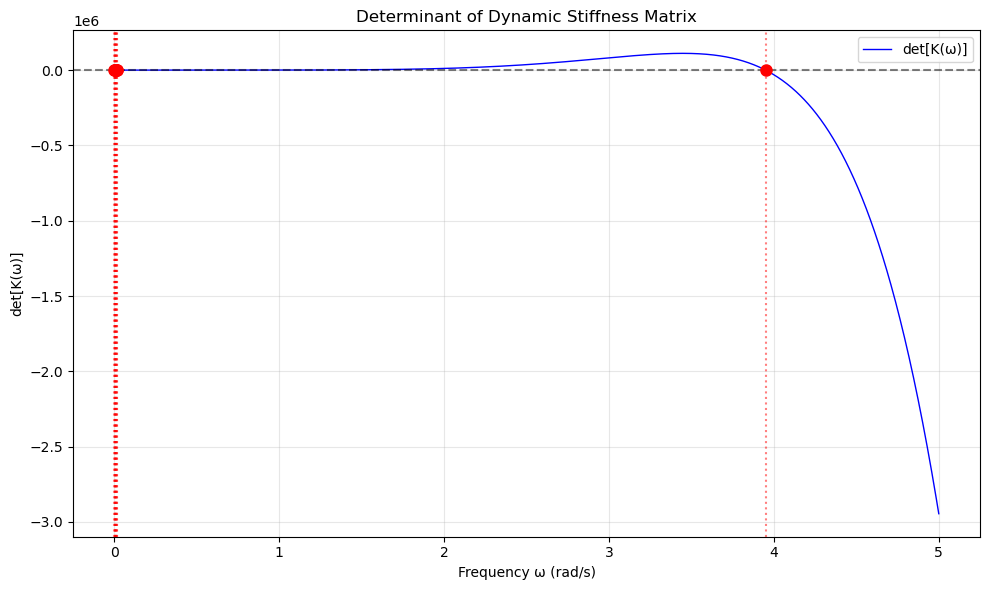

Found 9 natural frequencies


C:\Users\31633\AppData\Local\Temp\ipykernel_23900\3691701405.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  K_eval = np.array(K_func(float(omega)), dtype=np.complex128)


Found complex roots: [3.94981577-3.j   3.94981577-2.75j 3.94981577-2.5j  3.94981577-2.25j
 3.94981577-2.j   3.94981577-1.75j 3.94981577-1.5j  3.94981577-1.25j
 3.94981577-1.j   3.94981577-0.75j 3.94981577-0.5j  3.94981577-0.25j
 3.94981577+0.j   3.94981577+0.25j 3.94981577+0.5j  3.94981577+0.75j
 3.94981577+1.j   3.94981577+1.25j 3.94981577+1.5j  3.94981577+1.75j
 3.94981577+2.j   3.94981577+2.25j 3.94981577+2.5j  3.94981577+2.75j
 3.94981577+3.j  ]


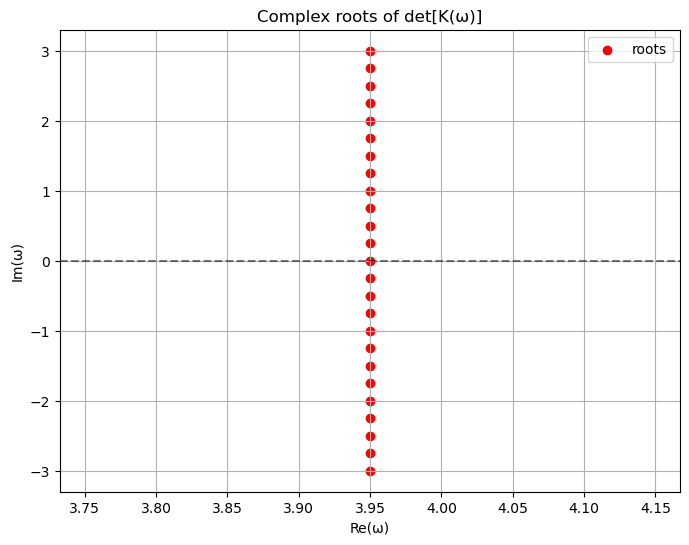

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(omega_grid, f_grid, 'b-', linewidth=1, label='det[K(ω)]')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)

# Mark found roots
for r in omega_n:
    plt.axvline(x=r, color='r', linestyle=':', alpha=0.5)
    plt.plot(r, 0, 'ro', markersize=8)

plt.xlabel('Frequency ω (rad/s)')
plt.ylabel('det[K(ω)]')
plt.title('Determinant of Dynamic Stiffness Matrix')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Found {len(omega_n)} natural frequencies")

# -----------------------------
# Find complex roots of det(K) in the complex ω-plane
# -----------------------------
from scipy.optimize import root

def F_xy(xy):
    om = xy[0] + 1j*xy[1]
    val = detK_numeric(om)
    return [np.real(val), np.imag(val)]

# Grid of initial guesses (adjust ranges if needed)
re_vals = np.linspace(0.1, 5.0, 20)
im_vals = np.linspace(-3.0, 3.0, 25)
roots_complex = []

for xr in re_vals:
    for yi in im_vals:
        guess = [xr, yi]
        try:
            sol = root(F_xy, guess, tol=1e-8, method='hybr')
            if sol.success:
                x,y = sol.x
                omc = x + 1j*y
                res = detK_numeric(omc)
                if abs(res) < 1e-6:
                    # Uniqueness filter
                    if not any(abs(omc - r) < 1e-4 for r in roots_complex):
                        roots_complex.append(omc)
        except Exception:
            pass

roots_complex = np.array(roots_complex)
print('Found complex roots:', roots_complex)

# Plot complex roots in the complex plane
plt.figure(figsize=(8,6))
if roots_complex.size > 0:
    plt.scatter(roots_complex.real, roots_complex.imag, c='r', label='roots')
else:
    plt.text(0.5, 0.5, 'No complex roots found in search region', transform=plt.gca().transAxes)
plt.axhline(0,color='k',linestyle='--',alpha=0.5)
plt.xlabel('Re(ω)')
plt.ylabel('Im(ω)')
plt.title('Complex roots of det[K(ω)]')
plt.grid(True)
plt.legend()
# Annotate only if not too many roots
if roots_complex.size > 0 and roots_complex.size <= 20:
    for omc in roots_complex:
        plt.annotate(f"{omc.real:.3f}{omc.imag:+.3f}j", (omc.real, omc.imag))
plt.show()

# Finding the modal shape and normalise the mode

In [49]:
modes = []
for wn in omega_n:
    K_eval = np.array(K_func(wn), dtype=np.complex128)
    U, S, Vh = np.linalg.svd(K_eval)
    Cn = Vh[-1,:]
    
    subsdict = dict(zip(Cvec, Cn))

    phi1 = W1.subs(subsdict).subs(vals) # Voeg subs(vals) toe om numerieke waarden in phi1 te krijgen
    phi2 = W2.subs(subsdict).subs(vals) 
    print(phi1)
    modes.append((wn, phi1, phi2))

norm_modes = []

for wn,phi1,phi2 in modes:

    Mn = sp.integrate(m1*phi1**2,(z,-h_num,0)) \
       + sp.integrate(m2*phi2**2,(z,0,H_num))

    phi1n = phi1/sp.sqrt(Mn)
    phi2n = phi2/sp.sqrt(Mn)

    norm_modes.append((wn,phi1n,phi2n))

print(norm_modes)
print(norm_modes[0])

-0.707112509070489*sin(0.000704194276605767*z*(19482.5868412371 + 16400.0*pi)**(1/4)*sqrt(Abs(wega))) - 1.53697059795396e-8*cos(0.000704194276605767*z*(19482.5868412371 + 16400.0*pi)**(1/4)*sqrt(Abs(wega))) + 0.707101053167626*sinh(0.000704194276605767*z*(19482.5868412371 + 16400.0*pi)**(1/4)*sqrt(Abs(wega))) - 1.53698733133368e-8*cosh(0.000704194276605767*z*(19482.5868412371 + 16400.0*pi)**(1/4)*sqrt(Abs(wega)))
-0.70725561507526*sin(0.000704194276605767*z*(19482.5868412371 + 16400.0*pi)**(1/4)*sqrt(Abs(wega))) - 2.03561256822953e-6*cos(0.000704194276605767*z*(19482.5868412371 + 16400.0*pi)**(1/4)*sqrt(Abs(wega))) + 0.706957856097997*sinh(0.000704194276605767*z*(19482.5868412371 + 16400.0*pi)**(1/4)*sqrt(Abs(wega))) - 2.03784779268863e-6*cosh(0.000704194276605767*z*(19482.5868412371 + 16400.0*pi)**(1/4)*sqrt(Abs(wega)))
-0.707398656414614*sin(0.000704194276605767*z*(19482.5868412371 + 16400.0*pi)**(1/4)*sqrt(Abs(wega))) - 5.58985807613333e-6*cos(0.000704194276605767*z*(19482.586841237

# Define wave forcing amplitude for given wave frequency

In [46]:
import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import quad
import time
import sympy as sp

# Parameters
N_modes = 3
Omega = 0.8      # wave frequency [rad/s]
Cm = 1 + Ca_num
g = 9.81
Hw = 6.0         # wave height [m]
zeta = 0.02      # damping ratio

print("Starting computation...")
start_time = time.time()

# Solve wave number (once, outside the loop)
def dispersion(k):
    return Omega**2 - g*k*np.tanh(k*h_num)

k = fsolve(dispersion, Omega**2 / g)[0]
print(f"Wave number k = {k:.4f} rad/m")

# Define water particle velocity function (numerical)
def Uw(z_val):
    return (Hw/2) * Omega * np.cosh(k * (z_val + h_num)) / np.sinh(k * h_num)

# Pre-calculate constants
inertia_term = rho_f_num * Cm * np.pi * D_num**2 / 4

# Loop through first N modes
modal_responses = []

# Define z as a symbol if not already defined
z = sp.symbols('z')

phi1_funcs = []
phi2_funcs = []
qns = []

for mode_idx in range(min(N_modes, len(norm_modes))):
    mode_start = time.time()
    
    wn, phi1n_sym, phi2n_sym = norm_modes[mode_idx]
    
    print(f"\n=== Mode {mode_idx+1} (ωn = {wn:.4f} rad/s) ===")
    
    # Convert symbolic expression to a numerical function using lambdify with proper modules
    # This is more reliable than repeated subs()
    try:
        # Try using lambdify first (fastest)
        phi1n_func = sp.lambdify(z, phi1n_sym, modules=['numpy', {'Abs': np.abs}])
        
        # Test the function
        test_val = phi1n_func(-5.0)
        if not isinstance(test_val, (int, float, complex)):
            test_val = float(test_val)
            
    except Exception as e:
        print(f"  Lambdify failed: {e}, using fallback method")
        
        # Fallback: create a wrapper that ensures float conversion
        def phi1n_func(z_val):
            # Substitute and evaluate, then force conversion to float
            result = phi1n_sym.subs(z, z_val).evalf()
            # Handle different return types
            if hasattr(result, 'as_real_imag'):
                # Complex number
                real, imag = result.as_real_imag()
                return complex(float(real), float(imag))
            else:
                # Real number
                return float(result)
    
    # Numerical integration for modal force
    def integrand(z_val):
        # Compute force at this z value
        phi_val = phi1n_func(z_val)
        uw_val = Uw(z_val)
        
        # Force = inertia_term * i*Omega * Uw * phi
        force_complex = inertia_term * (1j * Omega) * uw_val * phi_val
        return force_complex
    
    # Perform numerical integration over submerged portion
    try:
        # Use quad with complex integration by separating real and imaginary parts
        real_integrand = lambda z: np.real(integrand(z))
        imag_integrand = lambda z: np.imag(integrand(z))
        
        real_part, real_error = quad(real_integrand, -h_num, 0, limit=100)
        imag_part, imag_error = quad(imag_integrand, -h_num, 0, limit=100)
        
        Fn_num = real_part + 1j * imag_part
        
        # Calculate frequency response
        qn = Fn_num / (wn**2 - Omega**2 + 2j*zeta*wn*Omega)
        
        # Store results
        modal_responses.append({
            'mode': mode_idx + 1,
            'wn': wn,
            'Fn': Fn_num,
            'qn': qn,
            'amplitude': abs(qn),
            'phase': np.angle(qn, deg=True)
        })
        
        mode_time = time.time() - mode_start
        print(f"  Computation time: {mode_time:.2f} seconds")
        print(f"  Modal force Fn = {abs(Fn_num):.4e} N (magnitude)")
        print(f"  Response amplitude = {abs(qn):.4f} m")
        print(f"  Phase angle = {np.angle(qn, deg=True):.1f} degrees")
        
    except Exception as e:
        print(f"  Error in integration: {e}")
        # Fall back to trapezoidal rule with many points
        print("  Falling back to trapezoidal rule...")
        
        try:
            # Create many points for integration
            z_points = np.linspace(-h_num, 0, 200)
            
            # Evaluate at all points
            force_vals = []
            for z_val in z_points:
                phi_val = phi1n_func(z_val)
                uw_val = Uw(z_val)
                force_vals.append(inertia_term * (1j * Omega) * uw_val * phi_val)
            
            force_vals = np.array(force_vals)
            
            # Integrate using trapezoidal rule
            Fn_num = np.trapz(force_vals, z_points)
            
            # Calculate frequency response
            qn = Fn_num / (wn**2 - Omega**2 + 2j*zeta*wn*Omega)
            
            modal_responses.append({
                'mode': mode_idx + 1,
                'wn': wn,
                'Fn': Fn_num,
                'qn': qn,
                'amplitude': abs(qn),
                'phase': np.angle(qn, deg=True)
            })
            
            print(f"  Modal force Fn = {abs(Fn_num):.4e} N (magnitude)")
            print(f"  Response amplitude = {abs(qn):.4f} m")
            
        except Exception as e2:
            print(f"  Trapezoidal rule also failed: {e2}")
            continue

total_time = time.time() - start_time
print(f"\nTotal computation time: {total_time:.2f} seconds")

# Summary table
if modal_responses:
    print("\n" + "="*70)
    print("SUMMARY OF MODAL RESPONSES")
    print("="*70)
    print(f"{'Mode':<6} {'ωn (rad/s)':<12} {'|Fn| (N)':<15} {'|qn| (m)':<12} {'Phase (°)':<10} {'Ω/ωn':<8}")
    print("-"*70)
    
    for resp in modal_responses:
        print(f"{resp['mode']:<6} {resp['wn']:<12.4f} {abs(resp['Fn']):<15.4e} "
              f"{resp['amplitude']:<12.4f} {resp['phase']:<10.1f} {Omega/resp['wn']:<8.3f}")
    
    # Find dominant mode
    dominant_mode = max(modal_responses, key=lambda x: x['amplitude'])
    print("\n" + "="*70)
    print(f"DOMINANT MODE: Mode {dominant_mode['mode']}")
    print(f"  Frequency ratio Ω/ωn = {Omega/dominant_mode['wn']:.3f}")
    print(f"  Response amplitude = {dominant_mode['amplitude']:.4f} m")
    
    # Check if any mode is near resonance
    print("\nRESONANCE CHECK:")
    for resp in modal_responses:
        ratio = Omega/resp['wn']
        if 0.8 < ratio < 1.2:
            print(f"  Mode {resp['mode']} is NEAR RESONANCE (Ω/ωn = {ratio:.3f})")

Starting computation...
Wave number k = 0.0665 rad/m

=== Mode 1 (ωn = 0.0001 rad/s) ===
  Lambdify failed: loop of ufunc does not support argument 0 of type Abs which has no callable sqrt method, using fallback method
  Error in integration: Cannot convert expression to float
  Falling back to trapezoidal rule...
  Trapezoidal rule also failed: Cannot convert expression to float

=== Mode 2 (ωn = 0.0026 rad/s) ===
  Lambdify failed: loop of ufunc does not support argument 0 of type Abs which has no callable sqrt method, using fallback method
  Error in integration: Cannot convert expression to float
  Falling back to trapezoidal rule...
  Trapezoidal rule also failed: Cannot convert expression to float

=== Mode 3 (ωn = 0.0051 rad/s) ===
  Lambdify failed: loop of ufunc does not support argument 0 of type Abs which has no callable sqrt method, using fallback method
  Error in integration: Cannot convert expression to float
  Falling back to trapezoidal rule...
  Trapezoidal rule also 

In [47]:
import matplotlib.pyplot as plt

# Analyze frequency sweep for first few modes
Omega_range = np.linspace(0.1, 3.0, 100)  # Frequency range [rad/s]

# Store results for each mode
frequency_responses = []

for mode_idx in range(min(N_modes, len(norm_modes))):
    wn, phi1n, phi2n = norm_modes[mode_idx]
    
    responses = []
    for Omega_val in Omega_range:
        # Recompute wave number for each frequency
        k_val = fsolve(lambda k: Omega_val**2 - g*k*np.tanh(k*h_num), 
                      Omega_val**2/g)[0]
        
        # Modal force
        Fn_sym = sp.integrate(rho_f * Cm * sp.pi * D**2/4 * sp.I * Omega_val * 
                             (Hw/2)*Omega_val*sp.cosh(k_val*(z+h_num))/sp.sinh(k_val*h_num) * phi1n,
                             (z, -h_num, 0))
        
        Fn_num = complex(Fn_sym.subs({rho_f: rho_f_num, D: D_num}).evalf())
        
        # Response
        qn = Fn_num / (wn**2 - Omega_val**2 + 2j*zeta*wn*Omega_val)
        responses.append(abs(qn))
    
    frequency_responses.append(responses)

# Plot
plt.figure(figsize=(10, 6))
for mode_idx, responses in enumerate(frequency_responses):
    plt.plot(Omega_range, responses, label=f'Mode {mode_idx+1} (ωn={norm_modes[mode_idx][0]:.2f} rad/s)')

plt.xlabel('Wave Frequency Ω (rad/s)')
plt.ylabel('Response Amplitude |qn| (m)')
plt.title('Modal Frequency Response')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

TypeError: Cannot convert expression to float